## Increasing Diversity Hiring in City of LA through Text and Sentiment Analysis of Job Postings

**Challenge:**

The City of Los Angeles faces a big hiring challenge: one third of its 50,000 workers are eligible to retire by July of 2020. The city has partnered with Kaggle to create a competition to improve the job bulletins it will use to fill all those open positions.
The content, tone, and format of job descriptions can influence the quality of the applicant pool. Overly-specific requirements, for example, may discourage diversity. The Los Angeles Mayor’s Office wants to reimagine the city’s job bulletins by using text analysis to identify where they can improve.

**Goal:**
The goal is to convert a folder full of plain-text job postings into a structured CSV file and then to use this data to:
1. Identify language that can negatively bias the pool of applicants; 
2. Improve the diversity and quality of the applicant pool; 
3. Make it easier to determine which promotions are available to employees in each job class.

## PART 1: JOB POSTING TEXT BULLETIN TO STRUCTURED CSV FILE:

In [143]:
#Necessary imports. All open source libraries using python 3.6
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
import nltk
import string
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk import word_tokenize
import random
import dateutil.parser as dparser
from datetime import datetime
import datefinder
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import sent_tokenize
from wordcloud import WordCloud, STOPWORDS
from flashtext import KeywordProcessor
import os
from __future__ import unicode_literals, print_function
import plac
import spacy

Load the data of job bulletins into a List of text, also load the filenames (to be used later), derive the job position from the filename for some preliminary analysis (actual position for data dictionary will be derived from job bulletin)

In [144]:
def load_jobopening_dataset():

    data_path = 'CityofLA/Job Bulletins'

    texts = []
    positions = []
    file_names=[]
    for fname in sorted(os.listdir(data_path)):
        if fname.endswith('.txt'):
            file_names.append(fname)
            with open(os.path.join(data_path, fname),"rb") as f:
                texts.append(str(f.read()))
                positions.append((re.split(' (?=class)', fname))[0])
    
    #print the length of the List of text, length of file_names and positions and make sure they are all equal
    return (texts,positions,file_names)

job_data, positions, file_names = load_jobopening_dataset()

In [145]:
job_data[0].replace("\\r\\n"," ").replace("\\\'s","")[:250]

"b'311 DIRECTOR Class Code:       9206 Open Date:  04-18-14 ANNUAL SALARY   $125,175 to $155,514   DUTIES  A 311 Director is responsible for the successful operation and expansion of the 311 Call Center in the Information Technology Agency (ITA) which"

**Provided documents:**

In [146]:
#Let us print a job bulletin for reference, in its original form (after replacing \\r\\n)
titles = pd.read_csv("CityofLA/Additional data/job_titles.csv", header=None)
titles.head()

,0
0,311 DIRECTOR
1,ACCOUNTANT
2,ACCOUNTING CLERK
3,ACCOUNTING RECORDS SUPERVISOR
4,ADMINISTRATIVE ANALYST


In [147]:
data_dict=pd.read_csv("CityofLA/Additional data/kaggle_data_dictionary.csv")
data_dict

,Field Name,Annotation Letter,Description,Data Type,Allowable Values,Accepts Null Values?,Additional Notes
0,FILE_NAME,NaN,The file name of the job bulletin from which e...,String,NaN,No,NaN
1,JOB_CLASS_TITLE,A,"The title of the particular class (e.g., Syste...",String,Any job title matching in in supplied job bull...,No,NaN
2,JOB_CLASS_NO,B,The 4-digit code that corresponds to the job c...,String,Any four character numeric string matching one...,No,Some classes have three non-zero digits — e.g....
3,REQUIREMENT_SET_ID,D1,A main requirement that has to be filled. Thes...,Integer,Any positive integer,No,NaN
4,REQUIREMENT_SUBSET_ID,D2,"A secondary requirement that has to be filled,...",String,Any letter or combination of letters.,No,"A-Z represents 1-26. In the case of 27th, 28th..."
5,JOB_DUTIES,C,A summary of what someone does in the particul...,String,NaN,No,NaN
6,EDUCATION_YEARS,F,Years required in a particular education program,Float,Any positive float representing years or a fra...,Yes,Any job description that mentions months shoul...
7,SCHOOL_TYPE,G,School Type: School type required (e.g. colleg...,String,"COLLEGE OR UNIVERSITY, HIGH SCHOOL, APPRENTICE...",Yes,Allowable value list is most likely incomplete...
8,EDUCATION_MAJOR,H,Major or concentration required,String,NaN,Yes,A list of many sufficient majors should appear...
9,EXPERIENCE_LENGTH,I,Years required in a particular job class or ex...,Float,NaN,Yes,Some classes may specify months rather than ye...


**Creating the Parsers:**

In this section, I will create different parsers to extract different information from the text bulletin. Those information are based on the content of sample output file and the field name of data dictionary, which includes:
1. JOB_CLASS_TITLE
2. JOB_CLASS_NO
3. REQUIREMENT_SET_ID
4. REQUIREMENT_SUBSET_ID
5. JOB_DUTIES
6. EDUCATION_YEARS
7. SCHOOL_TYPE
8. EDUCATION_MAJOR
9. EXPERIENCE_LENGTH
10. FULL_TIME_PART_TIME
11. EXP_JOB_CLASS_TITLE
12. EXP_JOB_CLASS_ALT_RESP
13. EXP_JOB_CLASS_FUNCTION
14. COURSE_COUNT
15. COURSE_LENGTH
16. COURSE_SUBJECT
17. MISC_COURSE_DETAILS
18. DRIVERS_LICENSE_REQ
19. DRIV_LIC_TYPE
20. ADDTL_LIC
21. EXAM_TYPE
22. ENTRY_SALARY_GEN
23. ENTRY_SALARY_DWP
24. OPEN_DATE

We would need 24 parsers for 24 collumns of the output csv file, the parsers are defined as function below:

In [149]:
def Position_parser(s):
    title_match=False
    pos = re.findall(r'(.*?)Class Code',s)
    pos1 = re.findall(r'(.*?)Class  Code',s)
    if (len(pos1) > 0):
        pos = pos1
    if (len(pos) > 0):
        job_title= pos[0].replace("b'","").replace("b\"","").replace("'","").replace("\\","").strip()
        for title in titles[0]:
            if (title.replace("'","")==job_title):
                title_match=True
                break
    
    if(title_match==True):
        return job_title
    else:
        return "Invalid job title"
    
s = job_data[548].replace("\\r\\n"," ").replace("\\t","")

In [150]:
def JobCode_parser(s):
    job_code = 0
    code = re.findall(r'Class Code:(.*?)Open',s)
    if (len(code)>0):
        job_code= int(code[0].strip())
    return job_code

In [151]:
def OpenDate_parser(s):
    openDateRet=""
    openDate = re.findall(r'Open Date:(.*?)ANNUAL',s)
    openStr=""
    if (len(openDate)>0):
        #print(openDate)
        openDate = openDate[0].strip()
        openStr=re.findall(r'(?:Exam).*',openDate)
        #print(openStr)
    
    matches = list(datefinder.find_dates(openDate))

    if len(matches) > 0:
        for i in range(len(matches)):
            date = matches[i]
            openDateRet=str(date.date())
   
    return openDateRet,openStr


In [152]:
def SalaryRange_parser(s):
    salaryRange = re.findall(r'ANNUAL SALARY(.*?)NOTE',s)
    salaryRange_1 = re.findall(r'ANNUAL SALARY(.*?)DUTIES',s)
    salaryRange_2 = re.findall(r'ANNUAL SALARY(.*?)\(flat',s)
    len1=0
    len2=0
    len3=0
    if (len(salaryRange) > 0):
        len1 = len(salaryRange[0])
    if (len(salaryRange_1) > 0):
        len2 = len(salaryRange_1[0])
    if (len(salaryRange_2) > 0):
        len3 = len(salaryRange_2[0])
    if ((len1 > 0) & (len2 > 0)):
        if (len1 < len2):
            salaryRange = salaryRange
        else:
            salaryRange = salaryRange_1
        
    if (len(salaryRange)>0):
        salaryRange = salaryRange[0].strip()
        
    
    return salaryRange

In [153]:
def Qualification_parser(s):
    qual = re.findall(r'REQUIREMENTS/MINIMUM QUALIFICATIONS(.*?)WHERE TO APPLY',s)
    if (len(qual)==0):
        qual = re.findall(r'REQUIREMENT/MINIMUM QUALIFICATION(.*?)WHERE TO APPLY',s)
    if (len(qual)==0):
        qual = re.findall(r'REQUIREMENTS(.*?)WHERE TO APPLY',s)
    if (len(qual)==0):
        qual = re.findall(r'REQUIREMENT(.*?)WHERE TO APPLY',s)
    if (len(qual)>0):
        qual = qual[0].replace("\\'s","'s").strip()
    else:
        qual=""
    return qual

In [148]:
def filter_spans(spans):
    # Filter a sequence of spans so they don't contain overlaps
    get_sort_key = lambda span: (span.end - span.start, span.start)
    sorted_spans = sorted(spans, key=get_sort_key, reverse=True)
    result = []
    seen_tokens = set()
    for span in sorted_spans:
        if span.start not in seen_tokens and span.end - 1 not in seen_tokens:
            result.append(span)
            seen_tokens.update(range(span.start, span.end))
    return result


def extract_entity_relations(doc,entity):
    # Merge entities and noun chunks into one token
    seen_tokens = set()
    spans = list(doc.ents) + list(doc.noun_chunks)
    spans = filter_spans(spans)
    with doc.retokenize() as retokenizer:
        for span in spans:
            retokenizer.merge(span)

    relations = []
    for money in filter(lambda w: w.ent_type_ == entity, doc):
        if money.dep_ in ("attr", "dobj"):
            subject = [w for w in money.head.lefts if w.dep_ == "nsubj"]
            if subject:
                subject = subject[0]
                relations.append((subject, money))
        elif money.dep_ == "pobj" and money.head.dep_ == "prep":
            relations.append((money.head.head, money))
    return relations

In [154]:
nltk.download('punkt')
def Education_parser(s):
    educationMajor=""
    sentences = sent_tokenize(s)
    selected_sentences=[sent for sent in sentences if "major" in word_tokenize(sent)]
    for i in range(len(selected_sentences)):
        major = re.findall(r'major in(.*?),',selected_sentences[i])
        if (len(major)>0):
            educationMajor=major[0].strip()

    return educationMajor

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lykha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [155]:
def EduSemDur_parser(s):
    educationDur=""
    sentences = sent_tokenize(s)
    selected_sentences=[sent for sent in sentences if "semester" in word_tokenize(sent)]
    for i in range(len(selected_sentences)):
        dur = re.findall(r'(.*?)semester',selected_sentences[i])
        #print(dur)
        if (len(dur)>0):
            educationDur=dur[0]+'sememster'

    return educationDur

In [156]:
def Duties_parser(s):
    duties = re.findall(r'DUTIES(.*?)REQUIREMENT',s)
    jobDuties=""
    if (len(duties)>0):
        jobDuties= duties[0].strip()
    return jobDuties

In [157]:
def eduYears_parser(s):
    keyword_processor = KeywordProcessor()
    education_yrs=0.0
    keyword_processor.add_keyword('four-year')
    keyword_processor.add_keyword('four years')
    sentences = sent_tokenize(s)
    selected_sentences=[sent for sent in sentences if "degree" in word_tokenize(sent)]
    selected_sentences1=[sent for sent in sentences if "Graduation" in word_tokenize(sent)]

    for i in range(len(selected_sentences)):
        keywords_found = keyword_processor.extract_keywords(selected_sentences[i])
        if (len(keywords_found) > 0):
            education_yrs=4.0
    for i in range(len(selected_sentences1)):
        keywords_found = keyword_processor.extract_keywords(selected_sentences1[i])
        if (len(keywords_found) > 0):
            education_yrs=4.0
   
    return education_yrs


In [158]:
def expYears_parser(s):
    keyword_processor = KeywordProcessor()
    exp_yrs=0.0
    keyword_processor.add_keyword('four-year')
    keyword_processor.add_keyword('four years')
    keyword_processor.add_keyword('three years')
    keyword_processor.add_keyword('one year')
    keyword_processor.add_keyword('two years')
    keyword_processor.add_keyword('six years')
    sentences = sent_tokenize(s)
    selected_sentences=[sent for sent in sentences if "experience" in word_tokenize(sent)]

    for i in range(len(selected_sentences)):
        keywords_found = keyword_processor.extract_keywords(selected_sentences[i])
        for i in range(len(keywords_found)):
            if keywords_found[i]=='two years':
                exp_yrs=2.0
            elif keywords_found[i]=='one year':
                exp_yrs=1.0
            elif keywords_found[i]=='three years':
                exp_yrs=3.0
            elif keywords_found[i]=='six years':
                exp_yrs=6.0
            elif keywords_found[i]=='four years':
                exp_yrs=4.0
            elif keywords_found[i]=='four-year':
                exp_yrs=4.0
                
    return exp_yrs

In [159]:
def fullTimePartTime_parser(s):
    keyword_processor = KeywordProcessor()
    fullTimePartTime=""
    keyword_processor.add_keyword('full-time')
    keyword_processor.add_keyword('part-time')
    sentences = sent_tokenize(s)
    selected_sentences=[sent for sent in sentences if "experience" in word_tokenize(sent)]

    for i in range(len(selected_sentences)):
        keywords_found = keyword_processor.extract_keywords(selected_sentences[i])
        for i in range(len(keywords_found)):
            if keywords_found[i]=='full-time':
                fullTimePartTime="FULL TIME"
            elif keywords_found[i]=='part-time':
                fullTimePartTime="PART TIME"
           
                
    return fullTimePartTime

In [160]:
def DL_parser(s):
    dl = False
    dl_valid = False
    dl_State = ""
    arr = ['driver', 'license']
    keyword_processor = KeywordProcessor()
    keyword_processor.add_keyword('california')
    if any(re.findall('|'.join(arr), qual)):
        dl = True
    if (dl==True):
        sentences = sent_tokenize(s)
        selected_sentence=[sent for sent in sentences if "driver" in word_tokenize(sent)]
        if (len(selected_sentence)>0):
            words = selected_sentence[0].split()
            selected_word = [word for word in words if "valid" in words]
            if len(selected_word)>0:
                dl_valid=True
        for i in range(len(selected_sentence)):   
            keywords_found = keyword_processor.extract_keywords(selected_sentence[i])
            for i in range(len(keywords_found)):
                if keywords_found[i]=='california':
                    dl_State="CA"
                
    if (dl_valid)==True:
        dl_valid="R"
    else:
        dl_valid="P"
    return dl_valid,dl_State

In [161]:
def Relations_parser(TEXTS, nlp, ENTITY_TYPE):
    entities=[]
    for text in TEXTS:
        doc = nlp(text)
        relations = extract_entity_relations(doc,ENTITY_TYPE)
        for r1, r2 in relations:
            relation=r1.text+"-"+r2.text
            entities.append(relation)
    imp_entities='::::'.join(entities)   
    return imp_entities

In [162]:
def College_parser(s):
    college=""
    keyword_processor = KeywordProcessor()
    keyword_processor.add_keyword('college or university')
    keyword_processor.add_keyword('college')
    keyword_processor.add_keyword('university')
    keyword_processor.add_keyword('high school')
    sentences = sent_tokenize(s)
    for j in range(len(sentences)):
        sentence = sentences[j]
        keywords_found = keyword_processor.extract_keywords(sentence)
        if (len(keywords_found) > 0):
            for i in range(len(keywords_found) ):
                if (keywords_found[i]=='college or university'):
                    college='college or university'
                    break
                elif (keywords_found[i]=='college'):
                    college='college'
                    break
                elif (keywords_found[i]=='university'):
                    college='university'
                    break
                elif (keywords_found[i]=='high school'):
                    college='high school'
                    break
    

    return college

After defining all the parser funcions, we would need to put the parsers in a loop so it can go through each job bullentin text file (683 postings in total) and extract the information in each posting to place them nicely in a pandas dataframe. The process is as the follows:

In [ ]:
nlp = spacy.load("en_core_web_sm")

job_data_export=pd.DataFrame(columns=["FILE_NAME","JOB_CLASS_TITLE","JOB_CLASS_NO","REQUIREMENT_SET_ID",
                                      "REQUIREMENT_SUBSET_ID","JOB_DUTIES",
                                      "EDUCATION_YEARS","SCHOOL_TYPE","EDUCATION_MAJOR","EXPERIENCE_LENGTH","IMP_ENTITIES_QUAL",
                                     "FULL_TIME_PART_TIME","EXP_JOB_CLASS_TITLE","EXP_JOB_CLASS_ALT_RESP"
                                     ,"EXP_JOB_CLASS_FUNCTION","COURSE_COUNT","COURSE_LENGTH","COURSE_SUBJECT"
                                     ,"MISC_COURSE_DETAILS","DRIVERS_LICENSE_REQ","DRIV_LIC_TYPE",
                                     "ADDTL_LIC","EXAM_TYPE","ENTRY_SALARY_GEN","ENTRY_SALARY_DWP","OPEN_DATE","LEGAL_TERMS"])

for i in range(0, len(job_data)-1):

    s = job_data[i].replace("\\r\\n"," ").replace("\\t","")
    position = Position_parser(s)
    qual = Qualification_parser(s)
    DL_valid,DL_state = DL_parser(qual)
    education_yrs = eduYears_parser(qual)
    education_major = Education_parser(qual)
    job_code = JobCode_parser(s)
    try:
        openDate, openStr = OpenDate_parser(s)
    except:
        openDate = "NaN"
        openStr = "NaN"
    salaryRange = SalaryRange_parser(s)
    expYrs = expYears_parser(s)
    duties = Duties_parser(s)
    course_length = EduSemDur_parser(qual)
    fullTimePartTime = fullTimePartTime_parser(qual)
    imp_qual_entities=Relations_parser([qual],nlp,"ORG")
    imp_qual_cardinals=Relations_parser([qual],nlp,"CARDINAL")
    imp_legal_terms=Relations_parser([s],nlp,"LAW")
    college = College_parser(qual)
    job_data_export.loc[i,"JOB_CLASS_TITLE"]=position
    job_data_export.loc[i,"FILE_NAME"]=file_names[i]
    job_data_export.loc[i,"DRIVERS_LICENSE_REQ"]=DL_valid
    job_data_export.loc[i,"EDUCATION_YEARS"]=education_yrs
    job_data_export.loc[i,"JOB_CLASS_NO"]=job_code
    job_data_export.loc[i,"OPEN_DATE"]=openDate
    job_data_export.loc[i,"ENTRY_SALARY_GEN"]=salaryRange
    job_data_export.loc[i,"JOB_DUTIES"]=duties
    job_data_export.loc[i,"EXPERIENCE_LENGTH"]=expYrs
    job_data_export.loc[i,"DRIV_LIC_TYPE"]=DL_state
    job_data_export.loc[i,"EDUCATION_MAJOR"]=education_major
    job_data_export.loc[i,"IMP_ENTITIES_QUAL"]=imp_qual_entities
    job_data_export.loc[i,"COURSE_LENGTH"]=course_length
    job_data_export.loc[i,"FULL_TIME_PART_TIME"]=fullTimePartTime
    job_data_export.loc[i,"SCHOOL_TYPE"]=college
    job_data_export.loc[i,"MISC_COURSE_DETAILS"]=imp_qual_cardinals
    job_data_export.loc[i,"LEGAL_TERMS"]=imp_legal_terms
    job_data_export.loc[i,"EXAM_TYPE"]=openStr

It's quite the time-consuming process, let's see our final dataframe:

In [163]:
job_data_export.head()

,FILE_NAME,JOB_CLASS_TITLE,JOB_CLASS_NO,REQUIREMENT_SET_ID,REQUIREMENT_SUBSET_ID,JOB_DUTIES,EDUCATION_YEARS,SCHOOL_TYPE,EDUCATION_MAJOR,EXPERIENCE_LENGTH,...,COURSE_SUBJECT,MISC_COURSE_DETAILS,DRIVERS_LICENSE_REQ,DRIV_LIC_TYPE,ADDTL_LIC,EXAM_TYPE,ENTRY_SALARY_GEN,ENTRY_SALARY_DWP,OPEN_DATE,LEGAL_TERMS
0,311 DIRECTOR 9206 041814.txt,311 DIRECTOR,9206,NaN,NaN,A 311 Director is responsible for the successf...,4.0,college or university,NaN,2.0,...,NaN,relating-at least 50 call agents::::that-at le...,P,NaN,NaN,[],"$125,175 to $155,514",NaN,2014-04-18,NaN
1,ACCOUNTANT 1513 062218.txt,ACCOUNTANT,1513,NaN,NaN,An Accountant does professional accounting wor...,4.0,college or university,NaN,0.0,...,NaN,are-one semester::::their record-three or more...,R,CA,NaN,"['Exam Open to All, including Current City Emp...","$49,903 to $72,996 and $55,019 to $80,472",NaN,2018-06-22,NaN
2,ACCOUNTING CLERK 1223 071318.txt,ACCOUNTING CLERK,1223,NaN,NaN,An Accounting Clerk performs difficult and res...,0.0,college or university,NaN,1.0,...,NaN,Successful completion-6 semester or 9 quarter ...,P,NaN,NaN,"['Exam Open to All, including Current City Emp...","$49,005 to $71,618",NaN,2018-07-13,list-the Supplemental Questions Section::::lis...
3,ACCOUNTING RECORDS SUPERVISOR 1119 072718.txt,ACCOUNTING RECORDS SUPERVISOR,1119,NaN,NaN,"An Accounting Records Supervisor assigns, revi...",0.0,NaN,NaN,2.0,...,NaN,NaN,P,NaN,NaN,['Exam Open to Current City Employees)'],"$55,332 to $80,930 and $65,145 to $95,254",NaN,2018-07-27,NaN
4,ADMINISTRATIVE ANALYST 1590 060118.txt,ADMINISTRATIVE ANALYST,1590,NaN,NaN,An Administrative Analyst performs professiona...,4.0,college or university,NaN,1.0,...,NaN,their record-three or more moving violations,R,CA,NaN,['Exam Open to Current City Employees)'],"$60,489 to $88,468 and $71,451 to $104,462",NaN,2018-06-01,NaN


This is very similar to the samplesample job class export file as it is used as a template for this text mining process.  After we have the expected csv file, we would need to export it to an actual csv file using the to_csv functions from pandas package.

In [164]:
job_data_export.to_csv("LA_job_class_export.csv",index=False)

## PART 2: RAW TEXT ANALYSIS 

In this section, we will mainly perform out text analysis using the NLTK library, which is a top statistical natural language processing toolkit for English language written in the Python.

In [165]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lykha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

**1. How long (in words) is each job posting?**

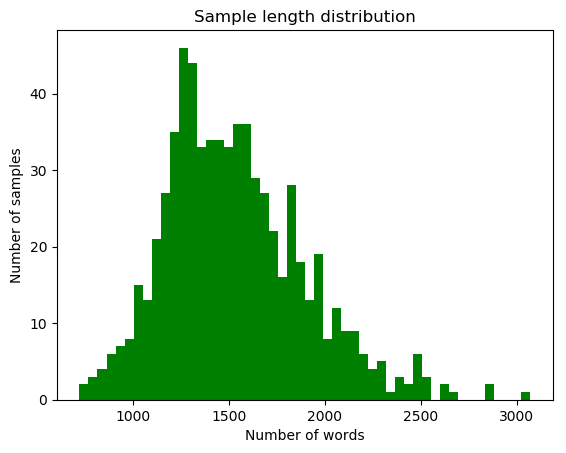

In [218]:
word_count = []
for s in job_data:
    word_count.append(len(s.split()))
    
plt.hist(word_count, 50, color="g")
plt.xlabel('Number of words')
plt.ylabel('Number of samples')
plt.title('Sample length distribution')
plt.show()

In [258]:
stats = pd.Series(word_count)
pd.DataFrame(stats.describe()[3:]).transpose()

,min,25%,50%,75%,max
0,723.0,1273.5,1483.0,1747.0,3070.0


As we can see in the histogram and the five-number summary table, the job posting is quite lenthy in words. The shortest text has 723 words and the longest reach to 3070 words. Looking at 2nd quantile, we can say that over 75% of the text have more than 1273.5 words. That lead to our next analysis quesion.

**2. Does the length of text effects the readability?**

In our test, we will calculate our readibility score based on the Flesch reading-ease test. The formula for the Flesch reading-ease score (FRES) test is

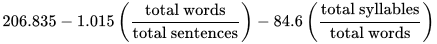

Higher scores indicate material that is easier to read; lower numbers mark passages that are more difficult to read. The following table can be helpful to assess the ease of readability in a document.
The table is an example of values. 

| Score        | School level       | Notes                                                                   |
|--------------|--------------------|-------------------------------------------------------------------------|
| 100.00-90.00 | 5th grade          | Very easy to read. Easily understood by an average 11-year-old student. |
| 90.0–80.0    | 6th grade          | Easy to read. Conversational English for consumers.                     |
| 80.0–70.0    | 7th grade          | Fairly easy to read.                                                    |
| 70.0–60.0    | 8th & 9th grade    | Plain English. Easily understood by 13- to 15-year-old students.        |
| 60.0–50.0    | 10th to 12th grade | Fairly difficult to read.                                               |
| 50.0–30.0    | College            | Difficult to read.                                                      |
| 30.0–0.0     | College graduate   | Very difficult to read. Best understood by university graduates.        |

*Note: While the maximum score is 121.22, there is no limit on how low the score can be. A negative score is valid.*

Luckily, the function of calculating Flesch reading-ease score is already built in the textstat package. We are going to use this library to analyze the readability of our raw text:

In [261]:
import textstat
score_list = []
for text in job_data:
    score_list.append(textstat.flesch_reading_ease(text))

In [262]:
readability = job_data_export[["FILE_NAME"]]
readability["WORD COUNTS"]=word_count[:len(score_list)-1]
readability["SCORE"] = score_list[:len(score_list)-1]
readability.head(10)

C:\Users\lykha\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\lykha\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,FILE_NAME,WORD COUNTS,SCORE
0,311 DIRECTOR 9206 041814.txt,1531,-14.24
1,ACCOUNTANT 1513 062218.txt,1642,-9.20
2,ACCOUNTING CLERK 1223 071318.txt,1602,4.24
3,ACCOUNTING RECORDS SUPERVISOR 1119 072718.txt,1270,-29.57
4,ADMINISTRATIVE ANALYST 1590 060118.txt,1830,-24.80
5,ADMINISTRATIVE CLERK 1358 033018 (2).txt,1310,-19.52
6,ADMINISTRATIVE HEARING EXAMINER 9135 100915.txt,1605,-7.48
7,ADVANCE PRACTICE PROVIDER CORRECTIONAL CARE 23...,1114,-73.73
8,AIR CONDITIONING MECHANIC 3774 041417.txt,1856,-14.24
9,AIR CONDITIONING MECHANIC SUPERVISOR 3781 1116...,1750,-17.66


In [259]:
rstats = readability["SCORE"].describe()[3:]
pd.DataFrame(rstats).transpose()

,min,25%,50%,75%,max
SCORE,-351.7,-30.9725,-20.435,-11.03,14.43


Our max score is 14.43, which fall in the range 0-29 (very difficult to read), and the majority of the text data are negative numbers. This can be intepreted as the job postings are beyond the highest difficulty level to read in Flesch reading-ease test. Beside the lengthy words, the job posters may include many technical jargons and difficult requirements to understand in one reading. This may scare the applicants away since it make the job position seems harder than they actually are. 



**3. How can we fix this readability problem?**

That said, it’s a good idea to cut down your long lists not matter what—one study found that **the average jobseeker spends just 49.7 seconds reviewing a listing before deciding it’s not a fit.** Therefore, here're some suggestions to fix this problem: 

**Limit your job requirements to “must-haves”:**

Your hiring manager might have an unending list of qualifications in mind for a given role, but in order to highlight your commitment to inclusion, it’s important to trim the list down. That’s because studies show that while men are likely to apply to jobs for which they meet only 60% of the qualifications, women are much more likely to hesitate unless they meet 100% of the listed requirements. Instead of including all of the “nice-to-haves” that a dream candidate might possess, stick to the “must-haves,” and you’ll likely see your applications from women candidates increase. Or if you’d still like to call out certain desired skills, you can soften the message with language like “familiarity with,” “bonus points for,” or “if you have any combination of these skills.”

**Avoid using unnecessary corporate speak and jargon:**

One of the quickest ways to turn off candidates is to include loads of unnecessary jargon in your descriptions. That includes things like KPIs, procurement, SLAs, P&L, and so on. While candidates with plenty of experience in a similar role might know what you’re talking about, studies show jargon and corporate language in job postings is one of the biggest barriers keeping talented young people from applying to entry-level positions. These subtle word choices can make some candidates feel unqualified for a position that they’re absolutely qualified for. “Insider language is a quick way to make someone else feel like an outsider, but if you’re not watching out for it, acronyms and ‘company speak’ will inevitably creep into your job descriptions,” says HubSpot’s Hannah Fleishman. “When in doubt, assume the candidate doesn’t know the ins-and-outs of your company.”

*For example, instead of using technical acronyms and business terms in your requirements, aim for more universal wording, like “pays attention to details” or “personable with customers.”*

## PART 3: SENTIMENT ANALYSIS:

**1. Cleaning the data:**

In order to perform sentiment analysis, we need to clean up the raw data to extract only the essential features. With that being said, we first need to tokenize the text. Tokenization is the process of breaking down a text paragraph into smaller chunks such as words or sentence. We also need to remove unnecessary words by including them in stopword list. In this case, "city, los angeles, and may" are removed since they shows up as most frequent words and does not carry much weights in our classification process later.

In [166]:
exclude = set(string.punctuation) 
wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')
#
newStopWords = ['city','los','angele','angeles','may']
stop_words.extend(newStopWords)
table = str.maketrans('', '', string.punctuation)

lemma = WordNetLemmatizer()
porter = PorterStemmer()

We also perform Lexicon normalization. The normalization process considers another type of noise in the text. For example, "connection", "connected", "connecting" are reduced to the common word "connect". It reduces derivationally related forms of a word to a common root word.

In [198]:
def normalize_document(doc):
    #replace newline and tab chars
    doc = doc.replace("\\r\\n"," ").replace("\\\'s","").replace("\t"," ") #.split("b'")[1]
    # tokenize document
    tokens = doc.split()
    # remove punctuation from each word
    tokens = [w.translate(table) for w in tokens]
    # convert to lower case
    lower_tokens = [w.lower() for w in tokens]
    #remove spaces
    stripped = [w.strip() for w in lower_tokens]
    # remove remaining tokens that are not alphabetic
    words = [word for word in stripped if word.isalpha()]
    # filter stopwords out of document
    filtered_tokens = [token for token in words if token not in stop_words]
    #normalized = " ".join(lemma.lemmatize(word) for word in filtered_tokens)
    #join the tokens back to get the original doc
    doc = ' '.join(filtered_tokens)
    return doc

normalize_corpus = np.vectorize(normalize_document)
#apply the text normalization to list of job positions
norm_positions=[]
for text_sample in positions:
    norm_positions.append(normalize_document(text_sample))
#apply the text normalization to list of job ads
norm_corpus=[]
for text_sample in job_data:
    norm_corpus.append(normalize_document(text_sample))

**2. Sentiment analysis on n-grams:**

After we cleaning up the text to extract only the most important information, we are going to plot our normalized texts for further analysis.
First, we would plot a word clouds. It is a good visualization to show the most frequently used words in the job posting text. The more frequent a specific word appears in a source of textual data, the bigger and bolder it appears in the word cloud.

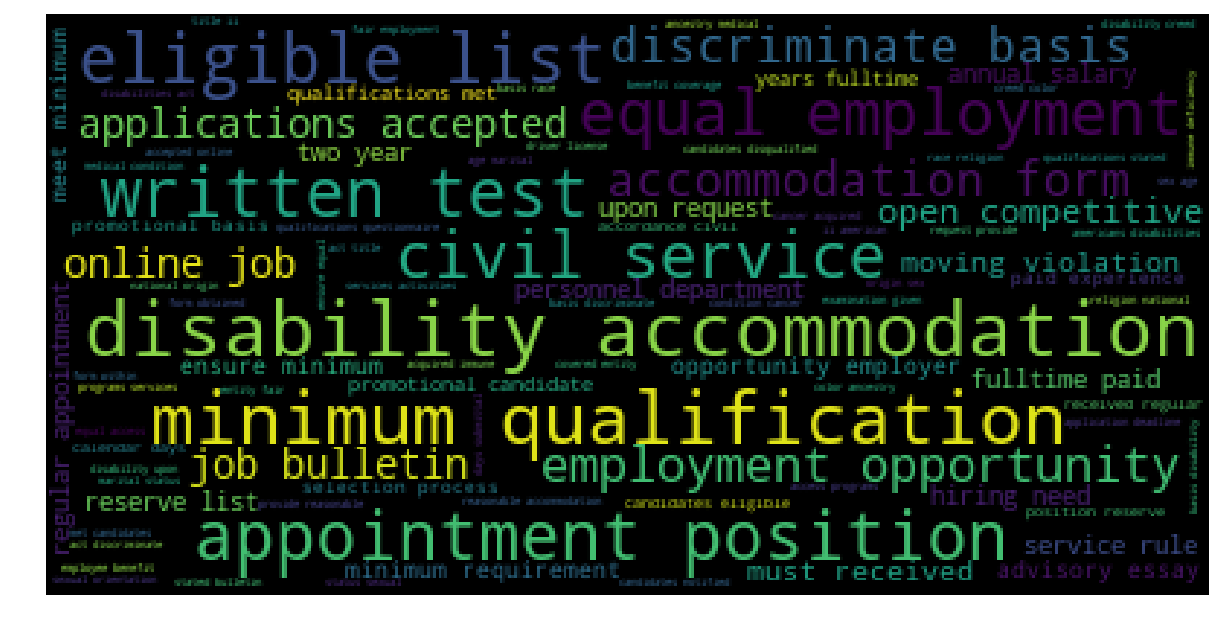

In [266]:
full_norm_corpus=' '.join(norm_corpus)
stopwords = set(STOPWORDS)
stopwords.update(["class", "code"])

wordcloud = WordCloud(stopwords=stopwords,max_words=100).generate(full_norm_corpus)
plt.figure(figsize=(15,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

From the word cloud, we can see some positive and negative keywords showing up:

**Positive words:** "disability accommodation", "civil service", "open competitive", "equal employment", "employment opportunity".

Those terms provoke a positive feeling that the employers really value diversity and welcome applicants from all backgrounds, genders and situations to apply. 

**Negative words:** "written test", "must received", "eligible list", "minimum qualification", "service rule", "reserve list"

These terms, in contrast, give a negative impression that the employers follow very strict rules and have many requirements for the job opening. That will discourage many applicants. 

We will create a n-grams function to extract longer terms and plot top 30 most frequent terms:

In [172]:
def ngrams(sample_texts, ngram_range, num_ngrams=30):
    """Plots the frequency distribution of n-grams.

    # Arguments
        samples_texts: list, sample texts.
        ngram_range: tuple (min, mplt), The range of n-gram values to consider.
            Min and mplt are the lower and upper bound values for the range.
        num_ngrams: int, number of n-grams to plot.
            Top `num_ngrams` frequent n-grams will be plotted.
    """
    # Create args required for vectorizing.
    kwargs = {
            'ngram_range': ngram_range,
            'dtype': 'int32',
            'strip_accents': 'unicode',
            'decode_error': 'replace',
            'analyzer': 'word',  # Split text into word tokens.
    }
    vectorizer = CountVectorizer(**kwargs)

    vectorized_texts = vectorizer.fit_transform(sample_texts)

    # This is the list of all n-grams in the index order from the vocabulary.
    all_ngrams = list(vectorizer.get_feature_names())
    num_ngrams = min(num_ngrams, len(all_ngrams))
    ngrams = all_ngrams[:num_ngrams]

    # Add up the counts per n-gram ie. column-wise
    all_counts = vectorized_texts.sum(axis=0).tolist()[0]

    # Sort n-grams and counts by frequency and get top `num_ngrams` ngrams.
    all_counts, all_ngrams = zip(*[(c, n) for c, n in sorted(
        zip(all_counts, all_ngrams), reverse=True)])
    ngrams = list(all_ngrams)[:num_ngrams]
    counts = list(all_counts)[:num_ngrams]
    return ngrams, counts


ngrams4, counts4 = ngrams(norm_corpus,ngram_range=(4, 4))    
ngrams30, counts30 = ngrams(norm_corpus,ngram_range=(30, 30))   

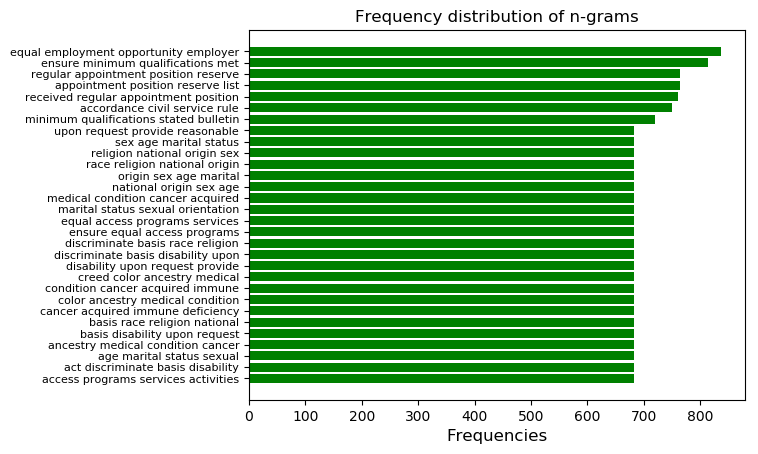

In [183]:
# Fixing random state for reproducibility
idx = np.arange(30)
np.random.seed(19680801)
plt.rcdefaults()
fig, ax = plt.subplots()
#horizontal
ax.barh(idx, counts4, align='center', color='g')
ax.set_yticks(idx)
ax.set_yticklabels(ngrams4, rotation=0, fontsize=8)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Frequencies',fontsize="12")
ax.set_title('Frequency distribution of n-grams',fontsize="12")

plt.show()

We will use the textblob library, which has a pre-trained machine learning model, to classify whether our 4-gram term are positive ore negative. By default, the NaiveBayesClassifier uses a simple feature extractor that indicates which words in the training set (movie reviews datset) are contained in a document. The textblob model take into consideration the tone and content of the text. An example of the classification can be:

In [272]:
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer
import nltk
#nltk.download('movie_reviews')
#nltk.download('punkt')

text          = "We only accept male applicants" 

sent          = TextBlob(text)
# The polarity score is a float within the range [-1.0, 1.0]
# where negative value indicates negative text and positive
# value indicates that the given text is positive.
polarity      = sent.sentiment.polarity
# The subjectivity is a float within the range [0.0, 1.0] where
# 0.0 is very objective and 1.0 is very subjective.
subjectivity  = sent.sentiment.subjectivity

sent          = TextBlob(text, analyzer = NaiveBayesAnalyzer())
classification= sent.sentiment.classification
positive      = sent.sentiment.p_pos
negative      = sent.sentiment.p_neg


dict1 = {'Polarity': polarity,'Subjectivity': subjectivity, 'Classification': classification, 'Posititve': positive, 'Negative': negative}
df1 = pd.Series(dict1)
df1

Polarity                 0
Subjectivity          0.55
Classification         neg
Posititve         0.326955
Negative          0.673045
dtype: object

In [274]:
def pos_neg_classify(text):
    sent          = TextBlob(text[0])
    # The polarity score is a float within the range [-1.0, 1.0]
    # where negative value indicates negative text and positive
    # value indicates that the given text is positive.
    polarity      = sent.sentiment.polarity
    # The subjectivity is a float within the range [0.0, 1.0] where
    # 0.0 is very objective and 1.0 is very subjective.
    subjectivity  = sent.sentiment.subjectivity

    sent          = TextBlob(text, analyzer = NaiveBayesAnalyzer())
    classification= sent.sentiment.classification
    positive      = sent.sentiment.p_pos
    negative      = sent.sentiment.p_neg
    return classification

In [276]:
pd.set_option('display.max_colwidth', -1)
df_4 = pd.DataFrame(ngrams4, columns=['N-grams Sentence'])
class_list4 = []
for text in ngrams4:
    classification = pos_neg_classify(text)
    class_list4.append(classification)
df_4["Class"] = class_list4
df_4

,N-grams Sentence,Class
0,equal employment opportunity employer,pos
1,ensure minimum qualifications met,neg
2,regular appointment position reserve,pos
3,appointment position reserve list,pos
4,received regular appointment position,pos
5,accordance civil service rule,pos
6,minimum qualifications stated bulletin,neg
7,upon request provide reasonable,pos
8,sex age marital status,pos
9,religion national origin sex,pos


In [277]:
pd.set_option('display.max_colwidth', -1)
df_30 = pd.DataFrame(ngrams30, columns=['N-grams Sentence'])
class_list30 = []
for text in ngrams30:
    classification = pos_neg_classify(text)
    class_list30.append(classification)
print(class_list)
df_30["Class"] = class_list30
df_30

NameError: name 'class_list' is not defined

## Suggestions:

**1. Re-word your job posting:**

Studies has found that the language you use in your job description helps to attract or turn off diverse candidates from applying to your open role. To attract more female candidates, avoid using too many “masculine-type” words (e.g., ambitious, dominate, challenging) in your job posting. Check out if your job posting might be turning off female candidates using this nifty tool here.

**2. Show your existing workplace diversity (or the diversity you aspire to):**

One of the biggest barriers to increasing workplace diversity is that diversity attracts diversity. Glassdoor found that 67% of job seekers use diversity is an important factor when considering companies and job offers. 
Take a look at the pictures and videos of your workplace on your website and social profiles. Pictures and videos of your employees should show their diversity. 

**3. Offer workplace flexibility:**

Research has found a strong predictor of employees’ quitting is a long commute. Because distance from downtown office locations is often correlated with more diverse neighbourhoods, offering work from home options and flexible work hours not only attract more diverse candidates, it helps decrease expensive turnover. 

**4. Encourage referrals from minority employees:**

In general, people’s social and professional networks are made up of people who are demographically similar. You can leverage this network similarity effect by encouraging minority employees to make referrals since they are more likely to refer members of their community. Minority employee referrals help increase your diversity hiring with the added benefits of hiring from referrals in the first place.


**Call out inclusive benefits like parental leave and childcare subsidies:**

You already know that benefits like paid parental leave, childcare subsidies, paid family sick time, and even health insurance go a long way toward supporting diversity and inclusion, while also boosting retention and morale. If your company offers these benefits, you may not realize the need to call them out in job descriptions—since not every employee will necessarily benefit from them—but mentioning them gives you an opportunity to prove your commitment to inclusion right away.  
You don’t have to include every benefit, but adding a few perks to your postings doesn’t hurt. After all, your job posting is likely to be your first touch point with a candidate, and jobseekers with families (or who are looking to start families at some point) will see the benefits mentioned in your descriptions as signals of your larger company values.
Because we all have biases that can be unconscious and unintentional, it’s always a good idea to revisit your job descriptions and make tweaks to make them more inclusive and, if applicable, showoff the great work your company is already doing to boost diversity and inclusion.

In [ ]:
print(job_data_export["JOB_CLASS_TITLE"][1])
print("*"*60)
print("Base salary:")
print(job_data_export["ENTRY_SALARY_GEN"][1])

In [ ]:
revised_jobposting = open('Diversity_Hiring.txt', 'r')
content = revised_jobposting.read()
print(content)

In [ ]:
print("Statistics of Revised Job Posting:")
numword = textstat.lexicon_count(content, removepunct=True)
score = textstat.flesch_reading_ease(content)
grade = textstat.flesch_kincaid_grade(text)
class1 = pos_neg_classify(content)
contentstat = pd.Series({"Word counts": numword, "Readbility Score": score, "Readability Level": "Grade " + str(int(grade)) , "Classification": class1})
contentstat